In [1]:
import os
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
!pwd

/home/ubuntu/workspace/pytorch_notes/domain_adaptation


In [7]:
from dataAPI import MNISTMDataset

# Prepare Data
image_size = 28
batch_size = 4

tf_source = transforms.Compose([
    transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])
tf_target = transforms.Compose([
    transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# Original MNIST dataset
ds_source = dset.MNIST(root=root, train=True, transform=tf_source, download=True)
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
# Custom MNISTM dataset
ds_target = MNISTMDataset(os.path.join(root, 'mnist_m', 'mnist_m_train'),
                         os.path.join(root, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

(<Figure size 576x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfcd6eb820>,
       dtype=object))

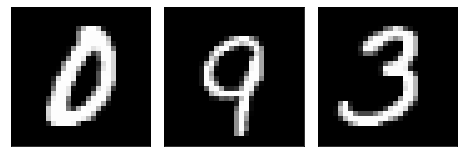

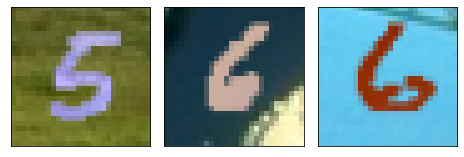

In [11]:
from plot_utils import dataset_first_n

# plot first n images
def plot_first_n(ds, n=3, cmap=None):
    
    max_cols = 5
    num_rows = math.ceil(n/max_cols)
    num_cols = n  if n < max_cols else max_cols
    print(f'subplot will have dimensions {num_rows}, {num_cols}')
    
    mnist_iter = iter(ds)
    i = 0
    f, axarr = plt.subplots(num_rows, num_cols)
    for mnist_data, _ in mnist_iter:
        
        ch, h, w = mnist_data.shape
        if num_rows > 1:
            axarr[math.floor(i/num_cols),i%num_cols].imshow(mnist_data.reshape(h,w,ch).squeeze(), cmap)
        else:
            axarr[i].imshow(mnist_data.reshape(h,w,ch).squeeze(), cmap)
        i += 1
        if i == n:
            break
    np.vectorize(lambda ax:ax.axis('off'))(axarr)
        
        
    
#plot_first_n(ds_source, n=3, cmap='gray')
#plot_first_n(ds_target, n=3)

dataset_first_n(ds_source,3,cmap='gray')
dataset_first_n(ds_target,3)


In [12]:
# gradient reversal
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors
# and define formulas for the forwawrd and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha
        
        # Must return same number as inputs to forward()
        return output, None

In [13]:
# Adverserial Network
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64,50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50*4*4,100), nn.BatchNorm1d(100), nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(100,100), nn.BatchNorm1d(100), nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(100,10),
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50*4*4, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100,2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimension
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred
             

In [14]:
model = DACNN().cuda()
x0_s, y0_s = next(iter(dl_source))
x0_t, y0_t = next(iter(dl_target))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)
x0_s = x0_s.cuda()
x0_t = x0_t.cuda()
model(x0_s)
model(x0_t)


source domain:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain:  torch.Size([4, 3, 28, 28]) torch.Size([4])


(tensor([[-3.2312, -2.7003, -1.8831, -1.7526, -1.6379, -3.3733, -2.5863, -2.6556,
          -1.8112, -3.5002],
         [-2.6910, -2.6012, -1.6860, -2.0630, -2.5157, -3.2207, -2.7131, -1.2961,
          -2.6798, -4.1090],
         [-1.6913, -2.4938, -2.9626, -1.8189, -2.9650, -2.8794, -1.7845, -2.0585,
          -2.3709, -3.7904],
         [-2.9101, -2.9688, -2.2144, -2.1910, -1.4943, -3.5876, -2.6090, -1.9724,
          -1.7049, -3.6288]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>),
 tensor([[-0.7226, -0.6646],
         [-1.0556, -0.4277],
         [-0.4652, -0.9889],
         [-0.5888, -0.8097]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>))

**Training**

In [15]:
lr = 1e-3
n_epochs = 10

# Setup optimizer as usual
model = DACNN().cuda()
optimizer = optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [16]:
batch_size = 1024
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target)) -1
print(max_batches)
'''
dl_iter = iter(dl_source)
for i in range(max_batches+1):
    element, _ = next(dl_iter)
    print(f'element #{i} has shape: {element.shape}')
'''

57


"\ndl_iter = iter(dl_source)\nfor i in range(max_batches+1):\n    element, _ = next(dl_iter)\n    print(f'element #{i} has shape: {element.shape}')\n"

In [17]:
model.train()
for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)
    
    for batch_idx in range(max_batches):
        optimizer.zero_grad()
        # Training progress and GRL Lambda
        p = float(((batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches))/2)
        grl_lambda = 2. / (1. + np.exp(-10*p)) - 1
        
        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        X_s, y_s = X_s.cuda(), y_s.cuda()
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels
        y_s_domain = y_s_domain.cuda()
        
        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)
        
        # Tran on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        X_t = X_t.cuda()
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels
        y_t_domain = y_t_domain.cuda()
        
        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        # Calculate total loss
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f'[{batch_idx+1}/{max_batches}] '
                  f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
                  f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
                 )
            
        
        

Epoch 0001 / 0010
[1/57] class_loss: 2.4584 s_domain_loss: 0.7831 t_domain_loss: 0.6756 grl_lambda: 0.000 
[11/57] class_loss: 1.2835 s_domain_loss: 0.6335 t_domain_loss: 0.7096 grl_lambda: 0.044 
[21/57] class_loss: 0.9343 s_domain_loss: 0.6033 t_domain_loss: 0.6848 grl_lambda: 0.087 
[31/57] class_loss: 0.7330 s_domain_loss: 0.5849 t_domain_loss: 0.6470 grl_lambda: 0.131 
[41/57] class_loss: 0.5529 s_domain_loss: 0.5661 t_domain_loss: 0.6244 grl_lambda: 0.174 
[51/57] class_loss: 0.4123 s_domain_loss: 0.5459 t_domain_loss: 0.6309 grl_lambda: 0.216 
Epoch 0002 / 0010
[1/57] class_loss: 0.3515 s_domain_loss: 0.5693 t_domain_loss: 0.5668 grl_lambda: 0.245 
[11/57] class_loss: 0.2831 s_domain_loss: 0.4974 t_domain_loss: 0.5296 grl_lambda: 0.286 
[21/57] class_loss: 0.2909 s_domain_loss: 0.5594 t_domain_loss: 0.5740 grl_lambda: 0.325 
[31/57] class_loss: 0.2896 s_domain_loss: 0.5134 t_domain_loss: 0.5782 grl_lambda: 0.364 
[41/57] class_loss: 0.2657 s_domain_loss: 0.5624 t_domain_loss: 0.

In [18]:
ts_source = dset.MNIST(root=root, train=False, transform=tf_source, download=True)
ts_target = MNISTMDataset(os.path.join(root, 'mnist_m', 'mnist_m_test'),
                         os.path.join(root, 'mnist_m', 'mnist_m_test_labels.txt'),
                         transform=tf_target)
batch_size1 = 1024
test_dl_source = torch.utils.data.DataLoader(ts_source, batch_size1)
test_dl_target = torch.utils.data.DataLoader(ts_target, batch_size1)
#dataset_first_n(ts_source,3,cmap='gray')
#dataset_first_n(ts_target,3)
max_batches1 = min(len(test_dl_source), len(test_dl_target))-1
num_samples = max_batches1 * batch_size1
print(num_samples)

#batch1_s = next(iter(test_dl_source))

#print(f'True class labels: {batch1_s[1]}')
#test_class, test_domain = model(batch1_s[0])
#print(f'test class prediction: {torch.argmax(test_class, dim=1)}, test domain prediction: {torch.argmax(test_domain, dim=1)}')

#total_correct = (batch1_s[1] == torch.argmax(test_class, dim=1)).sum().item() 
#print(type(float(total_correct)))







8192


In [23]:

test_source_iter = iter(test_dl_source)
test_target_iter = iter(test_dl_target)

s_class_labelled_correctly = 0
s_domain_labelled_correctly = 0
t_class_labelled_correctly = 0
t_domain_labelled_correctly = 0
model.eval()
# Evaluate training
for batch_idx in range(max_batches1):
    print(f'Batch {batch_idx+1:04d} / {max_batches1:04d}', end='\n=================\n')
    
    # source domain
    X_s, y_s = next(test_source_iter)
    X_s, y_s = X_s.cuda(), y_s.cuda()
    y_s_domain = torch.zeros(batch_size1, dtype=torch.long) # generate source domain labels   
    y_s_domain = y_s_domain.cuda()
    
    # Inference Source Domain
    Y_s_pred, Y_s_domain_pred = model(X_s)
    correct_class_pred = float((y_s == torch.argmax(Y_s_pred, dim=1)).sum().item())
    correct_domain_pred = float((y_s_domain == torch.argmin(Y_s_domain_pred, dim=1)).sum().item())
    print("============Source Domain Inference============")
    print(f'Class Accuracy: {correct_class_pred/batch_size1}, Domain Accuracry: {correct_domain_pred/batch_size1}')
    s_class_labelled_correctly += correct_class_pred
    s_domain_labelled_correctly += correct_domain_pred
    correct_class_pred = 0
    correct_domain_pred = 0
    
    # Target domain
    X_t, y_t = next(test_target_iter) # ignore target domain class labels!
    X_t, y_t = X_t.cuda(), y_t.cuda()
    y_t_domain = torch.ones(batch_size1, dtype=torch.long) # generate target domain labels
    y_t_domain = y_t_domain.cuda()
    
    # Inference Target Domain
    Y_t_pred, Y_t_domain_pred = model(X_t)
    correct_class_pred = float((y_t == torch.argmax(Y_t_pred, dim=1)).sum().item())
    correct_domain_pred = float((y_t_domain == torch.argmin(Y_t_domain_pred, dim=1)).sum().item())
    print("============Target Domain Inference============")
    print(f'Class Accuracy: {correct_class_pred/batch_size1:.3f}, Domain Accuracry: {correct_domain_pred/batch_size1:.3f}')
    t_class_labelled_correctly += correct_class_pred
    t_domain_labelled_correctly += correct_domain_pred
    correct_class_pred = 0
    correct_domain_pred = 0
    
print(f'+++++++++++++++Final Source Accuracy+++++++++++++++')
print(f'Class Accurary {s_class_labelled_correctly/num_samples:.3f}, Domain Accuracy: {s_domain_labelled_correctly/num_samples:.3f}')
print(f'+++++++++++++++Final Target Accuracy+++++++++++++++')
print(f'Class Accurary {t_class_labelled_correctly/num_samples:.3f}, Domain Accuracy: {t_domain_labelled_correctly/num_samples:.3f}')
     

Batch 0001 / 0008
============Source Domain Inference============
Class Accuracy: 0.9248046875, Domain Accuracry: 0.6630859375
============Target Domain Inference============
Class Accuracy: 0.214, Domain Accuracry: 0.809
Batch 0002 / 0008
============Source Domain Inference============
Class Accuracy: 0.9150390625, Domain Accuracry: 0.7119140625
============Target Domain Inference============
Class Accuracy: 0.190, Domain Accuracry: 0.786
Batch 0003 / 0008
============Source Domain Inference============
Class Accuracy: 0.923828125, Domain Accuracry: 0.69921875
============Target Domain Inference============
Class Accuracy: 0.199, Domain Accuracry: 0.783
Batch 0004 / 0008
============Source Domain Inference============
Class Accuracy: 0.9365234375, Domain Accuracry: 0.671875
============Target Domain Inference============
Class Accuracy: 0.219, Domain Accuracry: 0.783
Batch 0005 / 0008
============Source Domain Inference============
Class Accuracy: 0.9306640625, Domain Accuracry: 0.689

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [156]:
x = torch.rand(4,1,3,3)
print(x.shape)
y = torch.rand(4,3,3,3)
print(y.shape)

4
torch.Size([4, 3, 3, 3])


In [155]:
x3 = x.expand(x.data.shape[0], 3, 3, 3)
print(x3.shape)
y3 = y.expand(y.data.shape[0], 3, 3, 3)
print(y3.shape)
#y.data.shape

torch.Size([4, 3, 3, 3])
torch.Size([4, 3, 3, 3])


In [149]:
next(iter(dl_target))[0].shape

torch.Size([4, 3, 28, 28])

In [159]:
x = torch.rand(4,2)
print(x)

tensor([[0.4650, 0.3285],
        [0.2892, 0.7568],
        [0.1109, 0.1639],
        [0.7242, 0.3260]])


In [165]:
x2 = x.view(2, 4)
print(x2)

tensor([[0.4650, 0.3285, 0.2892, 0.7568],
        [0.1109, 0.1639, 0.7242, 0.3260]])
